<a href="https://colab.research.google.com/github/voquangtuong/AAA_drought_prediction/blob/main/M1M2M3_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library Import

In [ ]:
import os 
os.chdir('/content/drive/MyDrive/hybrid_model_final')
outs=['save_model_M1M2M3S1','tab_M1M2M3S1','fig_M1M2M3S1']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)

In [ ]:
####LIBRARY
import scipy
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, optimizers, backend
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras # tai sao import tu tensorflow
from tensorflow.keras.models import load_model

# import statsmodels as sm
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib
###  SET FONTS FOR PLOTTING
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
### cap nhat font
# plt.rcParams.update({'font.size': 14})

####RANDOM SEED SET
#tf.random.set_seed(10000000)
#np.random.seed(10000000)

####PANDAS LIB
from pandas import DataFrame
from pandas import concat


# Customize functions

In [ ]:

 
 ####cutomized sub.
def series_to_supervised_df(data, n_in, n_out, dropnan=True): # dung cho pandas
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
###############################################################################
# Create sample 
def create_sequences(data, window=5, step=1, prediction_distance=1):
    x = []
    y = []

    for i in range(0, len(data) - window - prediction_distance, step):
        x.append(data[i:i + window])
        y.append(data[i + window + prediction_distance][1])

    x, y = np.asarray(x), np.asarray(y)

    return x, y
	##############################################################################

  # functions nay dung cho array
def to_supervised_ar(data0, n_input, n_out):
  # flatten data
  data = data0.reshape((data0.shape[0]*data0.shape[1], data0.shape[1]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end < len(data):
      x_input = data[in_start:in_end, 0]
      x_input = x_input.reshape((len(x_input), 1))
      X.append(x_input)
      y.append(data[in_end+n_output0-1:out_end, 0]) # M2 tăng lên 1 bước
  # move along one time step
    in_start += 1
  return np.array(X), np.array(y)
	#################################################################################
	# ve duong 45 do
def add_identity(axes, *line_args, **line_kwargs):
	identity, = axes.plot([], [], *line_args, **line_kwargs)
	def callback(axes):
			low_x, high_x = axes.get_xlim()
			low_y, high_y = axes.get_ylim()
			low = max(low_x, low_y)
			high = min(high_x, high_y)
			identity.set_data([low, high], [low, high])
	callback(axes)
	axes.callbacks.connect('xlim_changed', callback)
	axes.callbacks.connect('ylim_changed', callback)
	return axes
	
	# ham de tao ra cac thu muc luu tru thong so optimal cua mo hinh
	# Helper record parameter into directory
def log_dir_name(epochs):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{}/"
		# s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(epochs)

    return log_dir

###################################################################################
# =============================================================================
# Customize activate functions
# Custom activation function
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


def custom_activation(x):
    return (K.sigmoid(x) * 3.5) 

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

# Read Raw Data and Generate the Dataset

In [ ]:
# # #READ the RAW DATA
# # url_NDI3_names="https://docs.google.com/spreadsheets/d/e/2PACX-1vT3LwwkD5v6sA75MNMbOPhLlHJpKSlEFZiG-7qZkk08rOYYSYfqtaqfqVOnW1eEfumW9rSsOvk8PLVS/pub?output=csv"

# # #RAWDATA
# # dataset0=pd.read_csv(url_NDI3_names,header=0)
# # dataset0.head()
# dataset0=pd.read_csv('05_calculate_out_rev/000201.txt',header=None,delim_whitespace=True )
# # save lai de khi nao can dung thi keu no ra
# dataset0.to_csv(outs[1]+'/'+'Ganghwnew'+'.csv')                    
# # print(dataset0)
# print(dataset0)
url_final='https://docs.google.com/spreadsheets/d/e/2PACX-1vS3xgiER8n9kt4SYpEwZR9X3KxQaJ5I05X_POl7BheoF_JK62-NB5O07eSl9_3BVQG0cT8j75D0v1qV/pub?output=csv'
dataset0=pd.read_csv(url_final,header=0)
dataset0

,Unnamed: 0,Y,M,P,R,S,P3,R3,S3,NDI3
0,0,1968,1,18.8,8.82,562.29,77.6,28.58,1674.11,-0.48
1,1,1968,2,11.1,7.67,561.68,44.6,28.94,1690.82,-0.41
2,2,1968,3,64.1,18.47,570.30,94.0,34.96,1694.27,-0.07
3,3,1968,4,20.1,27.62,571.97,95.3,53.76,1703.95,-0.33
4,4,1968,5,31.5,7.74,545.50,115.7,53.83,1687.77,-0.79
...,...,...,...,...,...,...,...,...,...,...
571,571,2015,8,51.0,12.75,530.48,275.7,82.99,1559.08,-3.35
572,572,2015,9,39.9,7.28,503.11,263.2,83.26,1553.23,-5.90
573,573,2015,10,51.5,12.89,516.34,142.4,32.92,1549.93,-2.48
574,574,2015,11,114.6,44.06,566.43,206.0,64.23,1585.88,-1.06


In [ ]:
# # #GANGHWA dung array old
# # dataset=dataset0.iloc[:,29]
# # print(dataset0.columns[29])
# dataset=np.array(dataset0.iloc[:,9].values)
# # print(dataset)
# train_ratio=0.6
# val_ratio=0.2
# test_ratio=0.2
# raw_seq=dataset[:int(dataset0.shape[0]*0.6)] # day la du lieu train
# raw_seq_val=dataset[int(dataset0.shape[0]*0.6):int(dataset0.shape[0]*0.8)] # day la du lieu validate
# raw_seq_test=dataset[int(dataset0.shape[0]*0.8):]
# print(len(raw_seq))
# print(len(raw_seq_test))

In [ ]:
# #GANGHWA dund dataframe new
# dataset=dataset0.iloc[:,29]
# print(dataset0.columns[29])
# dataset=dataset0.iloc[:,9]
# dataset.reset_index(drop=True,inplace=True)
dataset=dataset0['NDI3']
# dataset
print(dataset)
# train_ratio=0.6
# val_ratio=0.2
# test_ratio=0.2
# raw_seq=dataset.iloc[:int(dataset0.shape[0]*0.6)] # day la du lieu train
# raw_seq_val=dataset.iloc[int(dataset0.shape[0]*0.6):int(dataset0.shape[0]*0.8)] # day la du lieu validate
# raw_seq_test=dataset.iloc[int(dataset0.shape[0]*0.8):]
# print(raw_seq.shape)
# print(raw_seq_val.shape)
# print(raw_seq_test.shape)

0     -0.48
1     -0.41
2     -0.07
3     -0.33
4     -0.79
       ... 
571   -3.35
572   -5.90
573   -2.48
574   -1.06
575    0.43
Name: NDI3, Length: 576, dtype: float64


In [ ]:
## generate vector date 
vector_date=pd.date_range(start='1968-01',end='2015-12',freq='MS')
print(vector_date)

DatetimeIndex(['1968-01-01', '1968-02-01', '1968-03-01', '1968-04-01',
               '1968-05-01', '1968-06-01', '1968-07-01', '1968-08-01',
               '1968-09-01', '1968-10-01',
               ...
               '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01',
               '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01',
               '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', length=576, freq='MS')


 Chuyen data dang suppervised o day thi khi chia ra du lieu train, validate, testing cod doc lap khong

# Chuyen ve dang supervised

* bi mat het 7 gia tri du lieu tu 576 giam xuong con 569

Boi vi tu 1 cot gio thanh 8 cot

In [ ]:
n_in0,n_out0=5,3
df_supervised=series_to_supervised_df(pd.DataFrame(dataset),n_in=n_in0,n_out=n_out0)
df_supervised

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2)
5,-0.48,-0.41,-0.07,-0.33,-0.79,-1.52,-1.16,-0.89
6,-0.41,-0.07,-0.33,-0.79,-1.52,-1.16,-0.89,-0.63
7,-0.07,-0.33,-0.79,-1.52,-1.16,-0.89,-0.63,-0.07
8,-0.33,-0.79,-1.52,-1.16,-0.89,-0.63,-0.07,0.11
9,-0.79,-1.52,-1.16,-0.89,-0.63,-0.07,0.11,0.69
...,...,...,...,...,...,...,...,...
569,-0.74,-0.58,-1.08,-1.12,-1.46,-1.57,-2.13,-3.35
570,-0.58,-1.08,-1.12,-1.46,-1.57,-2.13,-3.35,-5.90
571,-1.08,-1.12,-1.46,-1.57,-2.13,-3.35,-5.90,-2.48
572,-1.12,-1.46,-1.57,-2.13,-3.35,-5.90,-2.48,-1.06


In [ ]:
df_supervised.head()

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2)
5,-0.48,-0.41,-0.07,-0.33,-0.79,-1.52,-1.16,-0.89
6,-0.41,-0.07,-0.33,-0.79,-1.52,-1.16,-0.89,-0.63
7,-0.07,-0.33,-0.79,-1.52,-1.16,-0.89,-0.63,-0.07
8,-0.33,-0.79,-1.52,-1.16,-0.89,-0.63,-0.07,0.11
9,-0.79,-1.52,-1.16,-0.89,-0.63,-0.07,0.11,0.69


In [ ]:
df_supervised.tail()

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2)
569,-0.74,-0.58,-1.08,-1.12,-1.46,-1.57,-2.13,-3.35
570,-0.58,-1.08,-1.12,-1.46,-1.57,-2.13,-3.35,-5.90
571,-1.08,-1.12,-1.46,-1.57,-2.13,-3.35,-5.90,-2.48
572,-1.12,-1.46,-1.57,-2.13,-3.35,-5.90,-2.48,-1.06
573,-1.46,-1.57,-2.13,-3.35,-5.90,-2.48,-1.06,0.43


khi du bao thi ket qua 1 thang se chay tu 1968-6: 2015-10

ket qua 2 thang tu 1968-7:2015-11

ket qua 3 thang tu 1968-8:2015-12

# Chia du lieu ra train/val/test:60:20:20

In [ ]:
# chieu dai cua train
n_train=int(df_supervised.shape[0]*0.6)
print(n_train)
n_val=int(df_supervised.shape[0]*0.8)-n_train
n_test=df_supervised.shape[0]-n_val-n_train
print(n_val)
print(n_test)

341
114
114


In [ ]:
train_df=df_supervised.iloc[0:n_train,:]
val_df=df_supervised.iloc[n_train:n_train+n_val,:]
test_df=df_supervised.iloc[n_train+n_val:,:]
print(train_df.shape,val_df.shape,test_df.shape)

(341, 8) (114, 8) (114, 8)


In [ ]:
train_df.head()

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2)
5,-0.48,-0.41,-0.07,-0.33,-0.79,-1.52,-1.16,-0.89
6,-0.41,-0.07,-0.33,-0.79,-1.52,-1.16,-0.89,-0.63
7,-0.07,-0.33,-0.79,-1.52,-1.16,-0.89,-0.63,-0.07
8,-0.33,-0.79,-1.52,-1.16,-0.89,-0.63,-0.07,0.11
9,-0.79,-1.52,-1.16,-0.89,-0.63,-0.07,0.11,0.69


In [ ]:
train_df.tail()

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2)
341,-0.90,-1.06,-0.75,-0.61,-0.78,0.09,1.02,0.38
342,-1.06,-0.75,-0.61,-0.78,0.09,1.02,0.38,-0.68
343,-0.75,-0.61,-0.78,0.09,1.02,0.38,-0.68,-1.44
344,-0.61,-0.78,0.09,1.02,0.38,-0.68,-1.44,-0.81
345,-0.78,0.09,1.02,0.38,-0.68,-1.44,-0.81,-0.22


In [ ]:
test_df.head()

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2)
460,0.52,0.26,0.21,-0.19,-0.99,0.20,0.88,1.66
461,0.26,0.21,-0.19,-0.99,0.20,0.88,1.66,1.02
462,0.21,-0.19,-0.99,0.20,0.88,1.66,1.02,0.16
463,-0.19,-0.99,0.20,0.88,1.66,1.02,0.16,-2.04
464,-0.99,0.20,0.88,1.66,1.02,0.16,-2.04,-1.77


In [ ]:
test_df.tail()

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2)
569,-0.74,-0.58,-1.08,-1.12,-1.46,-1.57,-2.13,-3.35
570,-0.58,-1.08,-1.12,-1.46,-1.57,-2.13,-3.35,-5.90
571,-1.08,-1.12,-1.46,-1.57,-2.13,-3.35,-5.90,-2.48
572,-1.12,-1.46,-1.57,-2.13,-3.35,-5.90,-2.48,-1.06
573,-1.46,-1.57,-2.13,-3.35,-5.90,-2.48,-1.06,0.43


Boi vi chua reset index net index cua data frame bat dau tu 5

x_train,y_train la cac gia tri cua train

x_val, y_val la gia tri cua val

x_test, y_test la gia tri cua tes

x_scale : sau khi duoc scale, x_rescaled la da duoc invert_scale

In [ ]:
x_train,y_train=train_df.iloc[:,0:5].values,train_df.iloc[:,5:].values
print(x_train.shape,y_train.shape)

x_val,y_val=val_df.iloc[:,0:5].values,val_df.iloc[:,5:].values
print(x_val.shape,y_val.shape)

x_test,y_test=test_df.iloc[:,0:5].values,test_df.iloc[:,5:].values
print(x_test.shape,y_test.shape)

(341, 5) (341, 3)
(114, 5) (114, 3)
(114, 5) (114, 3)


# Scale Max-Min data

In [ ]:
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)

# Tensorflow format

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
n_features=1
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))

# Setup model LSTM

In [ ]:
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Define models

In [ ]:
n_features = train_X.shape[2]

# define model
model = Sequential()
#model.add(LSTM(32,  activation = 'sigmoid', input_shape=(n_steps, n_features),return_sequences=True))
#model.add(LSTM(32,  activation = 'sigmoid', input_shape=(n_steps, n_features),return_sequences=True))
#model.add(LSTM(32,  activation = 'sigmoid', input_shape=(n_steps, n_features),return_sequences=True))
#model.add(LSTM(32,  activation = 'sigmoid', input_shape=(n_steps, n_features),return_sequences=True))
#model.add(LSTM(32,  activation = 'sigmoid', input_shape=(n_steps, n_features)))
# model.add(LSTM(32,  activation = 'tanh', input_shape=(n_steps, n_features)))
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(n_in0, n_features)))
model.add(Dense(n_out0))
# model.compile()
# model.summary()

## Setup the optimizer and callbacks

In [ ]:
opt = Adam(learning_rate = 0.001, clipnorm = 1.0)
model.compile(optimizer=opt, loss='mse')

#Keras Callbacks
#num_patience = 100
#es = EarlyStopping(monitor='val_loss', mode='min', patience = num_patience)
#checkpoint_path=model_save_path + ck_save #check point path
#checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_loss', verbose=1)
model.summary() #model summary Inflormation (optional)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 4,451
Trainable params: 4,451
Non-trainable params: 0
_________________________________________________________________


# Fit model ( trainning)

In [ ]:
# fit model
history1=model.fit(train_X, y_train_scale, epochs = 300, verbose=2, validation_data=(val_X,y_val_scale), batch_size = 32)

# save lai mo hinh
model.save(outs[0]+'/'+'vanila_LSTM'+'.tf',save_format='tf')

Epoch 1/300
11/11 - 2s - loss: 0.2242 - val_loss: 0.2337
Epoch 2/300
11/11 - 0s - loss: 0.1833 - val_loss: 0.1874
Epoch 3/300
11/11 - 0s - loss: 0.1442 - val_loss: 0.1418
Epoch 4/300
11/11 - 0s - loss: 0.1046 - val_loss: 0.0940
Epoch 5/300
11/11 - 0s - loss: 0.0702 - val_loss: 0.0557
Epoch 6/300
11/11 - 0s - loss: 0.0486 - val_loss: 0.0419
Epoch 7/300
11/11 - 0s - loss: 0.0436 - val_loss: 0.0403
Epoch 8/300
11/11 - 0s - loss: 0.0428 - val_loss: 0.0411
Epoch 9/300
11/11 - 0s - loss: 0.0422 - val_loss: 0.0392
Epoch 10/300
11/11 - 0s - loss: 0.0414 - val_loss: 0.0391
Epoch 11/300
11/11 - 0s - loss: 0.0411 - val_loss: 0.0391
Epoch 12/300
11/11 - 0s - loss: 0.0406 - val_loss: 0.0379
Epoch 13/300
11/11 - 0s - loss: 0.0403 - val_loss: 0.0376
Epoch 14/300
11/11 - 0s - loss: 0.0399 - val_loss: 0.0371
Epoch 15/300
11/11 - 0s - loss: 0.0396 - val_loss: 0.0367
Epoch 16/300
11/11 - 0s - loss: 0.0392 - val_loss: 0.0364
Epoch 17/300
11/11 - 0s - loss: 0.0389 - val_loss: 0.0362
Epoch 18/300
11/11 - 0s

# Check loss curves

[108] [0.03025232]


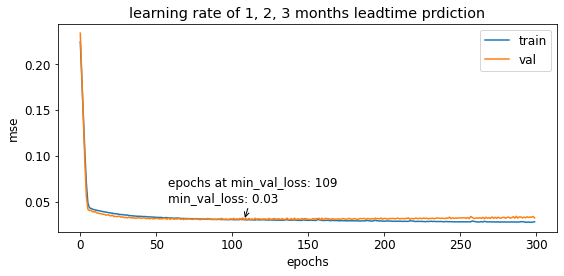

In [ ]:
#Check the Loss curve
fig,ax=plt.subplots(figsize=(8,4))
plt.rcParams.update({'font.size': 12})
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history1.history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train','val'])
plt.xlabel('epochs')
plt.ylabel('mse')
plt.title('learning rate of 1, 2, 3 months leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[2]+'/'+'M1M2M3S1_learning'+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)

# RESULTS

## Trainning

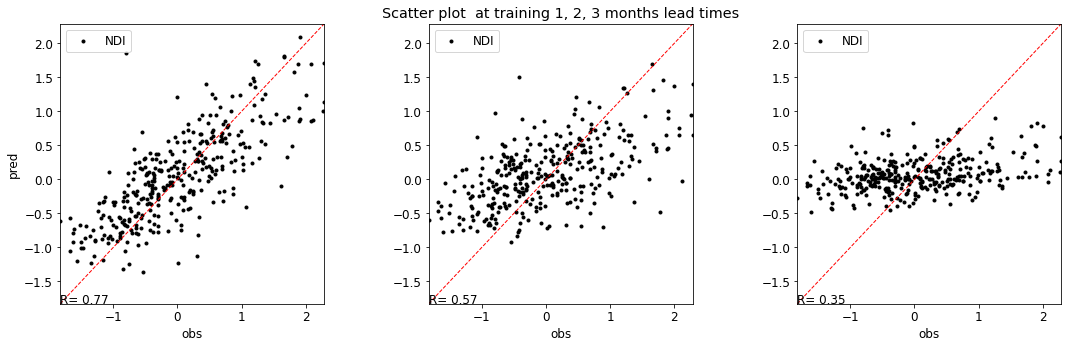

In [ ]:
#----------------------Important !!!!-----------------------#
pred = model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs
#--------------------------------------------------------------------#
# xuat ra 3 bieu do ket qua train cho 3 buoc
axes=[]
fig,ax=plt.subplots(figsize=(15,5))
plt.subplot(131)
pearson,dotincay=pearsonr(pred[:,0],obs[:,0])
r2_vanila_1m =pearson

# fig,ax=plt.subplots(figsize=(5,5))
min_values1=np.min([pred,obs])
min_values=min_values1
max_values1=np.max([pred,obs])
max_values=max_values1

plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)

plt.scatter(x=obs[:,0],
            y=pred[:,0],
            s=None,
            c='k', 
            marker='.', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None)

# ve duong 45
plt.legend(['NDI'])
plt.xlabel('obs')
plt.ylabel('pred')
# add_identity(ax, color='r', ls='--')
plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)
# plt.title('Scatter plot  at training 1, 2, 3 month lead times')
# ve hinh 2
plt.subplot(132)
pearson,dotincay=pearsonr(pred[:,1],obs[:,1])
r2_vanila_2m =pearson

# fig,ax=plt.subplots(figsize=(5,5))
min_values1=np.min([pred,obs])
min_values=min_values1
max_values1=np.max([pred,obs])
max_values=max_values1

plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)

plt.scatter(x=obs[:,1],
            y=pred[:,1],
            s=None,
            c='k', 
            marker='.', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None)

# ve duong 45
plt.legend(['NDI'])
plt.xlabel('obs')
# plt.ylabel('pred')
# add_identity(ax, color='r', ls='--')
plt.text(min_values,min_values,'R= '+str(round(r2_vanila_2m,2)))
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)
plt.title('Scatter plot  at training 1, 2, 3 months lead times')

# ve hinh 3
plt.subplot(133)
pearson,dotincay=pearsonr(pred[:,2],obs[:,2])
r2_vanila_3m =pearson

# fig,ax=plt.subplots(figsize=(5,5))
min_values1=np.min([pred,obs])
min_values=min_values1
max_values1=np.max([pred,obs])
max_values=max_values1

plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)

plt.scatter(x=obs[:,2],
            y=pred[:,2],
            s=None,
            c='k', 
            marker='.', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None)

# ve duong 45
plt.legend(['NDI'])
plt.xlabel('obs')
# plt.ylabel('pred')
# add_identity(ax, color='r', ls='--')
plt.text(min_values,min_values,'R= '+str(round(r2_vanila_3m,2)))
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

# plt.title('Scatter plot  at training 2 month lead times')
plt.tight_layout()
plt.savefig(outs[2]+'/'+'M1M2M3scatter_training'+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)

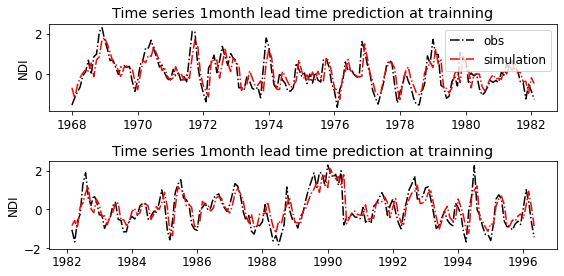

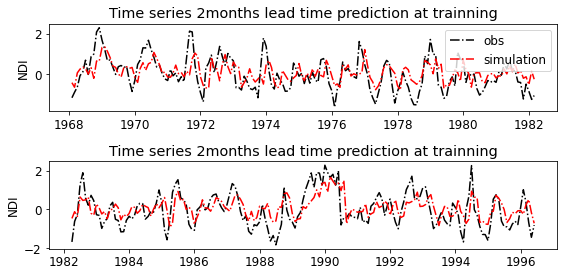

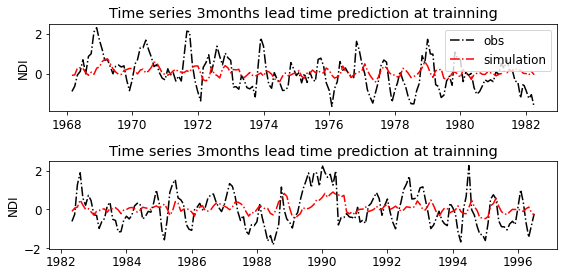

In [ ]:
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(3):
  fig,ax=plt.subplots(figsize=(8,4))
  plt.subplot(211)
  plt.rcParams.update({'font.size': 12})

  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  # plt.plot(vector_date[n_in0+lead_time:n_train-n_out0+lead_time+1], obs1[n_in0+lead_time:n_train-n_out0+lead_time+1,lead_time], 'k-.')
  # plt.plot(vector_date[n_in0+lead_time:n_train+-n_out0+lead_time+1], pred1[:,lead_time], 'r-.')
  
  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  plt.title('Time series '+months[lead_time] +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  plt.rcParams.update({'font.size': 12})
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  plt.title('Time series '+months[lead_time] +' lead time prediction at trainning')
  
  
  
  # plt.plot(vector_date[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)]+lead_time-n_out0+1, pred[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)+lead_time-n_out0+1,lead_time],'r-.')
  # plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[2]+'/'+months[lead_time]+'_training_times'+'.jpeg')
  plt.show()
  plt.close()

# Validation

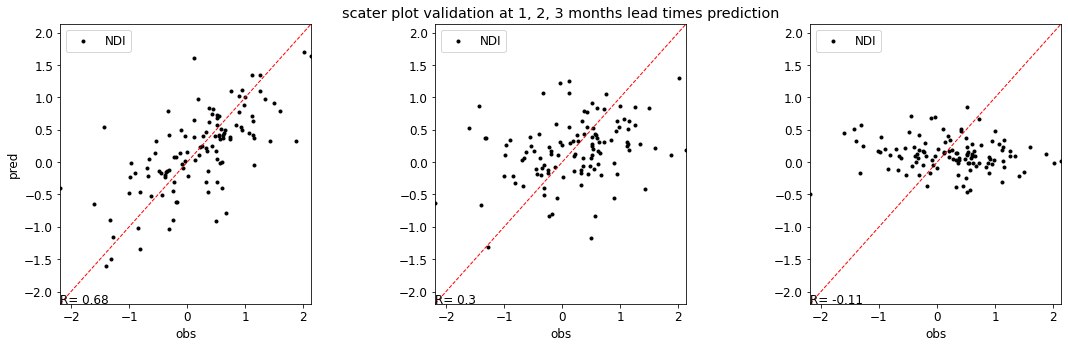

In [ ]:
pred = model.predict(val_X)  #(pred)  
obs  = y_val_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred2=pred
obs2=obs
#--------------------------------------------------------------------#
# xuat ra 3 bieu do ket qua train cho 3 buoc
fig,ax=plt.subplots(figsize=(15,5))
axes=[131,132,133]
for lead_time in range(3):
  plt.subplot(axes[lead_time])
  pearson,dotincay=pearsonr(pred2[:,lead_time],obs2[:,lead_time])
  r2_vanila_1m =pearson

  # fig,ax=plt.subplots(figsize=(5,5))
  min_values1=np.min([pred,obs])
  min_values=min_values1
  max_values1=np.max([pred,obs])
  max_values=max_values1

  plt.xlim(min_values,max_values)
  plt.ylim(min_values,max_values)

  plt.scatter(x=obs2[:,lead_time],
              y=pred2[:,lead_time],
              s=None,
              c='k', 
              marker='.', 
              cmap=None,
              norm=None,
              vmin=None, 
              vmax=None,
              alpha=None,            
              linewidths=None,
              edgecolors=None,plotnonfinite=False,data=None)

  # ve duong 45
  plt.legend(['NDI'])
  plt.xlabel('obs')
  if lead_time==0:
    plt.ylabel('pred')
  if lead_time==1:
    plt.title('scater plot validation at 1, 2, 3 months lead times prediction')
  # add_identity(ax, color='r', ls='--')
  plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
  xpoints = ypoints = plt.xlim()
  plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

  plt.tight_layout()
  plt.savefig(outs[2]+'/'+'M1M2M3_validation_scatter'+'.jpeg')
  # plt.show()
  # plt.close(fig)

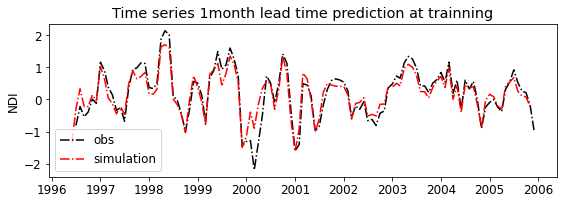

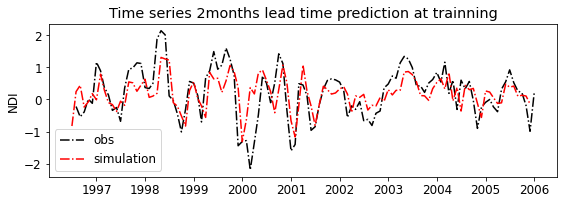

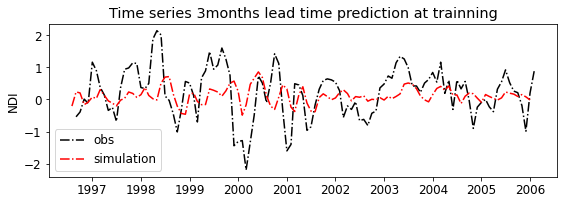

In [ ]:
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(3):
  fig,ax=plt.subplots(figsize=(8,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})

  plt.plot(vector_date[n_train+lead_time+1:n_train+lead_time+1+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')

  # plt.plot(vector_date[n_in0+lead_time:n_train-n_out0+lead_time+1], obs1[n_in0+lead_time:n_train-n_out0+lead_time+1,lead_time], 'k-.')
  # plt.plot(vector_date[n_in0+lead_time:n_train+-n_out0+lead_time+1], pred1[:,lead_time], 'r-.')
  
  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  plt.title('Time series '+months[lead_time] +' lead time prediction at trainning')
  plt.tight_layout()

  # plt.subplot(212)
  # plt.rcParams.update({'font.size': 12})
  # plt.plot(vector_date[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)+lead_time-n_out0+1], 
  #          obs[int(dataset0.shape[0]*0.3)+input:int(dataset0.shape[0]*0.6)+lead_time-n_out0+1,lead_time], 'k-.')
  
  # plt.plot(vector_date[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)]+lead_time-n_out0+1, pred[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)+lead_time-n_out0+1,lead_time],'r-.')
  # plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[2]+'/'+months[lead_time]+'_training_times'+'.jpeg')
  plt.show()
  plt.close()

# Testing

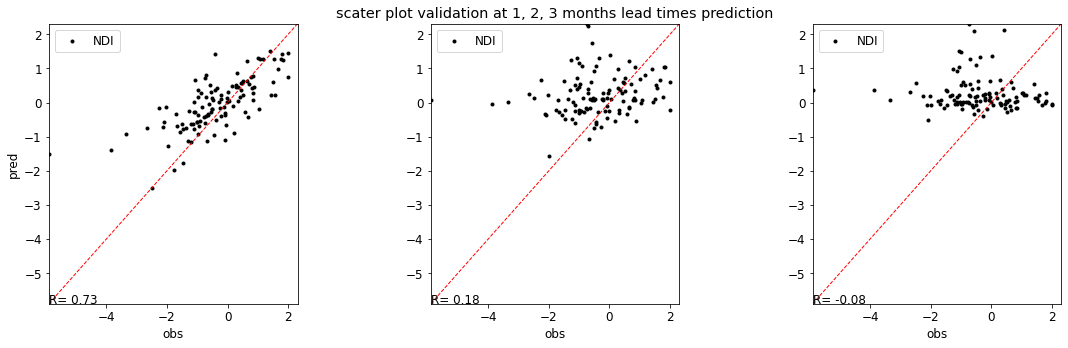

In [ ]:
pred = model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#
# xuat ra 3 bieu do ket qua train cho 3 buoc
fig,ax=plt.subplots(figsize=(15,5))
axes=[131,132,133]
for lead_time in range(3):
  plt.subplot(axes[lead_time])
  pearson,dotincay=pearsonr(pred3[:,lead_time],obs3[:,lead_time])
  r2_vanila_1m =pearson

  # fig,ax=plt.subplots(figsize=(5,5))
  min_values1=np.min([pred,obs])
  min_values=min_values1
  max_values1=np.max([pred,obs])
  max_values=max_values1

  plt.xlim(min_values,max_values)
  plt.ylim(min_values,max_values)

  plt.scatter(x=obs3[:,lead_time],
              y=pred3[:,lead_time],
              s=None,
              c='k', 
              marker='.', 
              cmap=None,
              norm=None,
              vmin=None, 
              vmax=None,
              alpha=None,            
              linewidths=None,
              edgecolors=None,plotnonfinite=False,data=None)

  # ve duong 45
  plt.legend(['NDI'])
  plt.xlabel('obs')
  if lead_time==0:
    plt.ylabel('pred')
  if lead_time==1:
    plt.title('scater plot validation at 1, 2, 3 months lead times prediction')
  # add_identity(ax, color='r', ls='--')
  plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
  xpoints = ypoints = plt.xlim()
  plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

plt.tight_layout()
plt.savefig(outs[2]+'/'+'M1M2M3_testing_scatter'+'.jpeg')
plt.show()

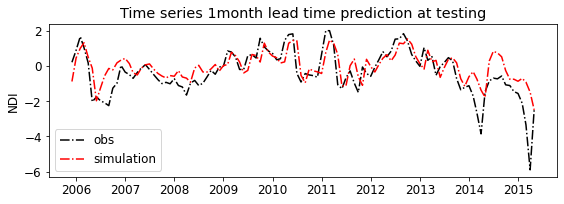

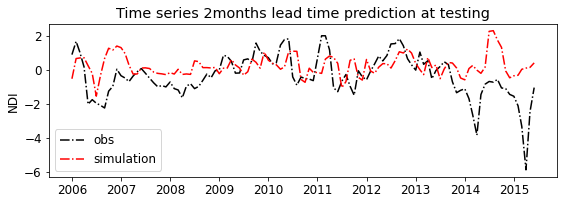

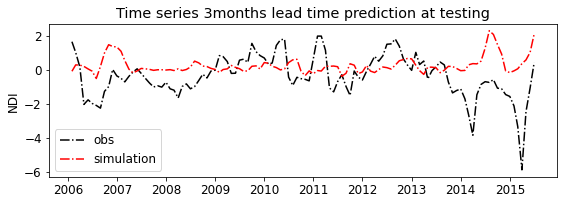

In [ ]:
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(3):
  fig,ax=plt.subplots(figsize=(8,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})

  plt.plot(vector_date[n_train+n_val+lead_time:n_train+n_val+lead_time+obs3.shape[0]],obs3[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+n_val+lead_time:n_train+n_val+lead_time+obs3.shape[0]],pred3[:,lead_time],'r-.')
  

  # plt.plot(vector_date[n_in0+lead_time:n_train-n_out0+lead_time+1], obs1[n_in0+lead_time:n_train-n_out0+lead_time+1,lead_time], 'k-.')
  # plt.plot(vector_date[n_in0+lead_time:n_train+-n_out0+lead_time+1], pred1[:,lead_time], 'r-.')
  
  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  plt.title('Time series '+months[lead_time] +' lead time prediction at testing')
  plt.tight_layout()

  # plt.subplot(212)
  # plt.rcParams.update({'font.size': 12})
  # plt.plot(vector_date[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)+lead_time-n_out0+1], 
  #          obs[int(dataset0.shape[0]*0.3)+input:int(dataset0.shape[0]*0.6)+lead_time-n_out0+1,lead_time], 'k-.')
  
  # plt.plot(vector_date[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)]+lead_time-n_out0+1, pred[int(dataset0.shape[0]*0.3):int(dataset0.shape[0]*0.6)+lead_time-n_out0+1,lead_time],'r-.')
  # plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[2]+'/'+months[lead_time]+'_training_times'+'.jpeg')
  plt.show()
  plt.close()

## Tong hop ket qua tung mo hinh

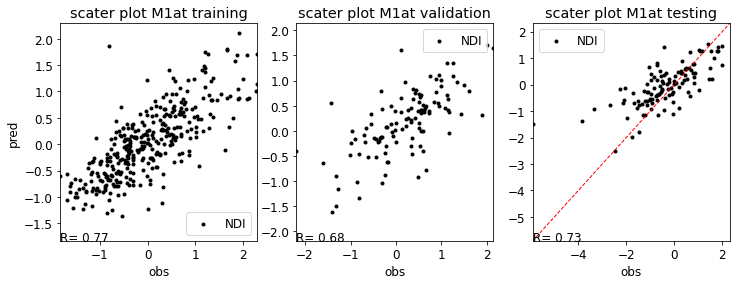

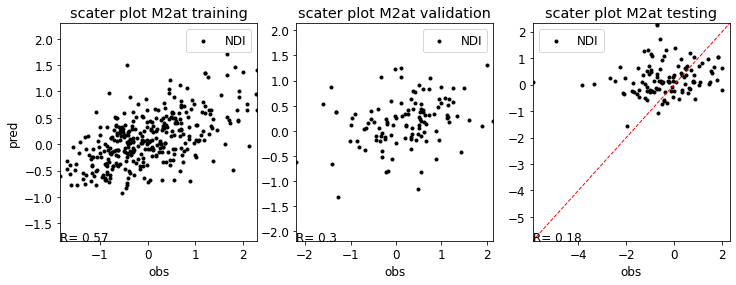

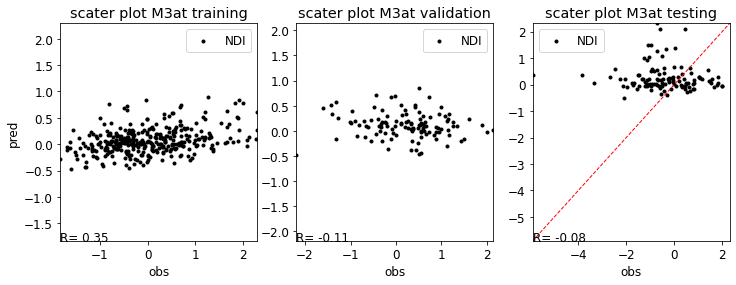

In [ ]:
# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','validation','testing']
for lead_time in range(3):
  fig,ax=plt.subplots(figsize=(12,4))
# lead_time=2
  for m in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[m])
    pearson,dotincay=pearsonr(pred_all[m][:,lead_time],obs_all[m][:,lead_time])
    r2_vanila_1m =pearson

    # fig,ax=plt.subplots(figsize=(5,5))
    min_values1=np.min([pred_all[m],obs_all[m]])
    min_values=min_values1
    max_values1=np.max([pred_all[m],obs_all[m]])
    max_values=max_values1

    plt.xlim(min_values,max_values)
    plt.ylim(min_values,max_values)

    plt.scatter(x=obs_all[m][:,lead_time],
                y=pred_all[m][:,lead_time],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    plt.legend(['NDI'])
    plt.xlabel('obs')
    if m==0:
      plt.ylabel('pred')
    # if lead_time==1:
    plt.title('scater plot '+'M'+str(lead_time+1)+'at '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    xpoints = ypoints = plt.xlim()
  plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)
  plt.savefig(outs[2]+'/'+months[lead_time]+'_M1M2M3'+'.jpeg')
  # plt.show()
    # plt.close(fig)

In [ ]:
# # Time series
# fig,ax=plt.subplots(figsize=(12,4))

# axes=[131,132,133]
# obs_all=[obs1,obs2,obs3]
# pred_all=[pred1,pred2,pred3]
# # lead_time=0
# names_phases=['training','validation','testing']
# # for lead_time in range(3):
# lead_time=2
# for m in range(3):
# # for lead_time in range(3):
#   plt.subplot(axes[m])
#   pearson,dotincay=pearsonr(pred_all[m][:,lead_time],obs_all[m][:,lead_time])
#   r2_vanila_1m =pearson

#   # fig,ax=plt.subplots(figsize=(5,5))
#   min_values1=np.min([pred_all[m],obs_all[m]])
#   min_values=min_values1
#   max_values1=np.max([pred_all[m],obs_all[m]])
#   max_values=max_values1

#   plt.xlim(min_values,max_values)
#   plt.ylim(min_values,max_values)

#   plt.scatter(x=obs_all[m][:,lead_time],
#               y=pred_all[m][:,lead_time],
#               s=None,
#               c='k', 
#               marker='.', 
#               cmap=None,
#               norm=None,
#               vmin=None, 
#               vmax=None,
#               alpha=None,            
#               linewidths=None,
#               edgecolors=None,plotnonfinite=False,data=None)

#   # ve duong 45
#   plt.legend(['NDI'])
#   plt.xlabel('obs')
#   if m==0:
#     plt.ylabel('pred')
#   # if lead_time==1:
#   plt.title('scater plot '+'M'+str(lead_time+1)+'at '+names_phases[m])
#   # add_identity(ax, color='r', ls='--')
#   plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
#   xpoints = ypoints = plt.xlim()
#   plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)
#     # plt.show()
#     # plt.close(fig)